In [7]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sb
from scipy.stats import skew
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from datetime import date, timedelta
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
import math

In [8]:
symbol = input("enter symbol here : ")

##### Fetch Live stock data 

In [9]:
import yfinance as yf

print(f"Fetching data for '{symbol}' using yfinance...")

try:
    # 2. Create a Ticker object
    sym_data = yf.Ticker(symbol)

    # 3. Fetch historical market data 
    data = sym_data.history(period="60d", interval="5m")

    data = data.reset_index()  # Reset index to make 'Datetime' a column
    # The column name after reset_index depends on the yfinance version,
    # it could be 'Datetime' or 'index'. We'll handle 'Datetime'.
    if "Datetime" in data.columns:
    #     # Format the 'Datetime' column to 'YYYY-MM-DD HH:MM'
        data["Datetime"] = data["Datetime"].dt.strftime("%Y-%m-%d %H:%M")
    elif "index" in data.columns:
        data = data.rename(columns={"index": "Datetime"})
        data["Datetime"] = data["Datetime"].dt.strftime("%Y-%m-%d %H:%M")

    # We now have the 'Datetime' column to include.
    data = data[["Datetime", "Open", "High", "Low", "Close", "Volume"]]

    # 7. Display the final data
    print("\nHere are the last 5 data points with the formatted Datetime column:")
    print(data.tail())

except Exception as e:
    print(f"\nAn error occurred: {e}")

Fetching data for 'CESC.NS' using yfinance...

Here are the last 5 data points with the formatted Datetime column:
              Datetime        Open        High         Low       Close  Volume
4495  2025-08-25 15:05  164.009995  164.699997  164.000000  164.570007   80192
4496  2025-08-25 15:10  164.570007  164.600006  164.339996  164.339996   22021
4497  2025-08-25 15:15  164.399994  164.470001  163.990005  164.229996   42734
4498  2025-08-25 15:20  164.119995  164.440002  164.119995  164.199997   38772
4499  2025-08-25 15:25  164.149994  164.240005  163.910004  164.240005       0


##### Neccesary Data pre-processing steps 

In [10]:
# Summary statistics of numerical columns
print("summary statistics  \n",data.describe().T)

summary statistics  
          count          mean           std         min          25%  \
Open    4500.0    170.581118      6.507992  160.429993   164.440002   
High    4500.0    170.768527      6.502329  160.589996   164.580002   
Low     4500.0    170.388707      6.505627  160.220001   164.307499   
Close   4500.0    170.581835      6.509381  160.350006   164.449997   
Volume  4500.0  42572.671778  75799.517553    0.000000  9716.250000   

                 50%           75%           max  
Open      169.179993    177.119995  1.829000e+02  
High      169.350006    177.385002  1.830000e+02  
Low       169.000000    176.872498  1.825400e+02  
Close     169.159996    177.110001  1.829000e+02  
Volume  20888.000000  46220.500000  1.803046e+06  


##### Stock Price Visualization 

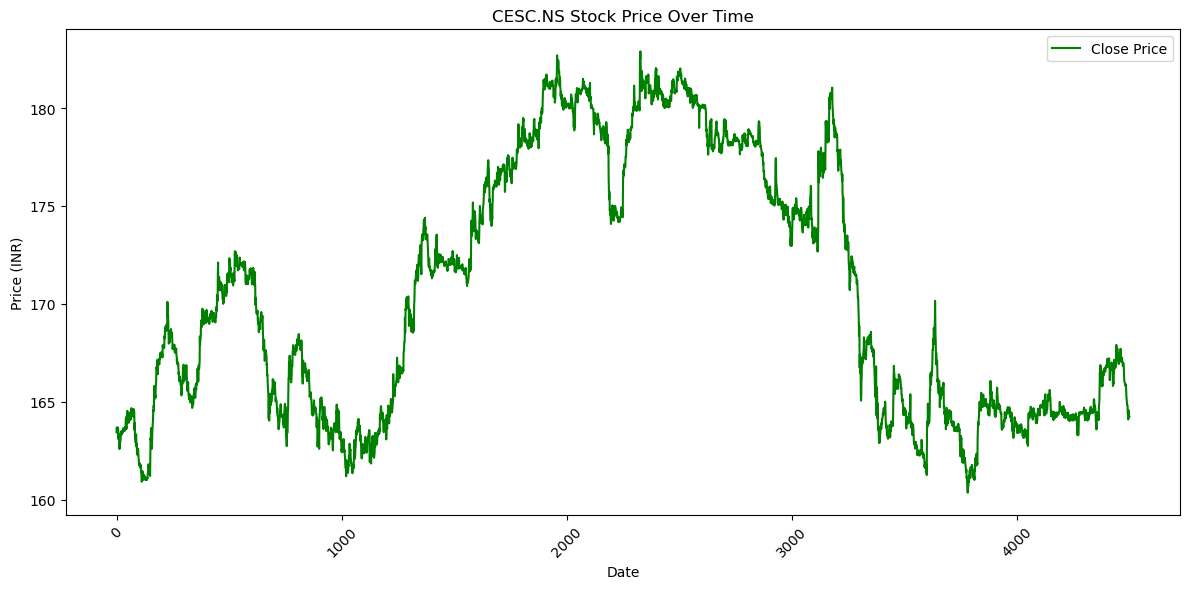

In [11]:
# stock price over the time using line chart
plt.figure(figsize=(12, 6))
sb.lineplot(data=data, x=data.index, y="Close", label="Close Price" , color="green")
plt.title(f"{symbol} Stock Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price (INR)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

##### Scatter plot shows the association between two variable (how much they're depended)

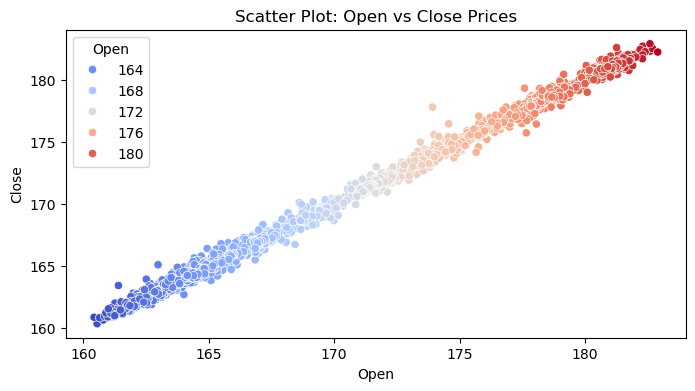

In [12]:
# Scatter plot between Open & Close prices
plt.figure(figsize=(8, 4))
sb.scatterplot(x=data['Open'], y=data['Close'], hue=data['Open'], palette='coolwarm')
plt.title("Scatter Plot: Open vs Close Prices")
plt.show()

##### Heatmap shows the correlations of all the numerical cols and shows how all are connected

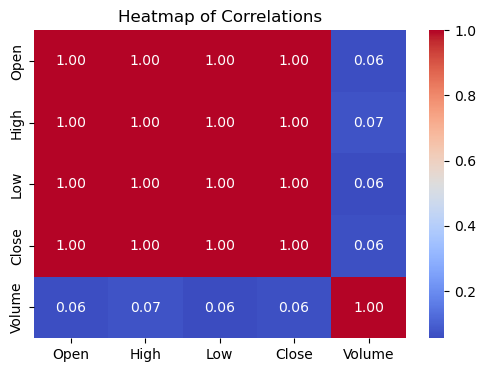

In [13]:
numeric_cols = data.select_dtypes(include=['float64', 'int64'])
# heatmap for visualizing relationships between numerical columns
plt.figure(figsize=(6, 4))
sb.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Heatmap of Correlations")
plt.show()

###### Rule of thumb:-
- 0.5 < skew < 0.5 → fairly symmetrical
- Otherwise → consider transformation

In [14]:
print("Skewness (Close):", skew(data['Close']))
print("Skewness (Open):", skew(data['Open']))
print("Skewness (High):", skew(data['High']))
print("Skewness (Low):", skew(data['Low']))
print("Skewness (Volume):", skew(data['Volume']))

Skewness (Close): 0.29670626601628347
Skewness (Open): 0.29707480715419765
Skewness (High): 0.2928927937706428
Skewness (Low): 0.2996963093127467
Skewness (Volume): 8.85979555119391


#### Skewness Analysis 
- Market data or live time series data has very uneven skewness which is more common and expected due high volatility and other factors on markets

In [15]:
# Volume:
# Extremely skewed — a few trading days have unusually high volumes.
# This can cause LSTM to overemphasize rare spikes.
# Solution : Log transformation to reduce skewness.

## As of now, we are not using volume in our model, but if we do, we can apply log transformation to reduce skewness in future. 

In [16]:
## Adding a trend column to the data
# This column indicates whether the price is expected to go up (1) or down (0
data['Trend'] = (data['Close'].shift(-1) > data['Close']).astype(int)

In [17]:
print("Overview of dataset after adding some features \n\n")
data = data.round(2)  # rounding off the values for better readability
print(data.tail())

Overview of dataset after adding some features 


              Datetime    Open    High     Low   Close  Volume  Trend
4495  2025-08-25 15:05  164.01  164.70  164.00  164.57   80192      0
4496  2025-08-25 15:10  164.57  164.60  164.34  164.34   22021      0
4497  2025-08-25 15:15  164.40  164.47  163.99  164.23   42734      0
4498  2025-08-25 15:20  164.12  164.44  164.12  164.20   38772      1
4499  2025-08-25 15:25  164.15  164.24  163.91  164.24       0      0


### LSTM MODEL

##### 1️⃣ Preparing Your Data for LSTM
###### LSTMs expect 3D input: [samples, timesteps, features]
where
```
samples = number of training examples
timesteps = how many past days to look back
features = number of columns (Open, High, Low, Close, Volume)
```

Step 1: Apply transformations & scaling

In [18]:
# Scale all features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[["Open", "High", "Low", "Close", "Volume"]])

Step 2: Create sequences(timesteps)

In [19]:
def create_sequences(dataset, time_steps=90):
    X, y = [], []
    for i in range(len(dataset) - time_steps):
        X.append(dataset[i:(i + time_steps)])  # past 60 days
        y.append(dataset[i + time_steps, 0])   # 'Close' is 1st column here
    # Convert to numpy arrays for better performance with LSTM
    return np.array(X), np.array(y)

time_steps = 60
X, y = create_sequences(scaled_data, time_steps)


Step 3: Train-test split (no shuffle)

In [20]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, {y_test.shape}")

Training data shape: (3552, 60, 5), (3552,)
Testing data shape: (888, 60, 5), (888,)


Step 4: LSTM model (Keras - RNN variant) 

In [ ]:
model = Sequential()
model.add(
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))
)
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))  # Predict close price

model.compile(optimizer="adam", loss="mean_squared_error")

history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1,
)

c:\Devs\anaconda_navigator\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0439 - val_loss: 5.1118e-04
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0038 - val_loss: 4.7013e-04
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0040 - val_loss: 4.1738e-04
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0032 - val_loss: 4.2943e-04
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0031 - val_loss: 3.6701e-04
Epoch 6/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0026 - val_loss: 3.6075e-04
Epoch 7/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0028 - val_loss: 3.7121e-04
Epoch 8/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0025 - val_loss: 3.6175e-04
Epoch 9/50
  1/111 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0026

Model evaluation metrics

In [ ]:
# Predictions
y_pred = model.predict(X_test)
# Inverse transform (to get actual prices back)
# y_test and y_pred are scaled — need to bring them back

# Create empty array for inverse scaling
y_test_inv = np.zeros((len(y_test), scaled_data.shape[1]))
y_pred_inv = np.zeros((len(y_pred), scaled_data.shape[1]))

# Put the close price predictions back in the correct column
y_test_inv[:, 3] = y_test
y_pred_inv[:, 3] = y_pred[:, 0]

# Inverse transform
y_test_inv = scaler.inverse_transform(y_test_inv)[:, 3]
y_pred_inv = scaler.inverse_transform(y_pred_inv)[:, 3]


In [ ]:
rmse = math.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)
print("RMSE:", rmse)
print("MAE:", mae)
print("R2 score:", r2)

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label="Actual Price")
plt.plot(y_pred_inv, label="Predicted Price")
plt.title(f"Actual vs Predicted Stock Price {symbol}")
plt.xlabel("Time")
plt.ylabel("Price (INR)")
plt.legend()
plt.show()

In [ ]:
# --- 1. User Input for Forecast Period ---
try:
    forecast_minutes = int(input("Enter the number of minutes to forecast (e.g., 15, 30, 60): "))
    if forecast_minutes <= 0:
        raise ValueError
except ValueError:
    print("Invalid input. Please enter a positive number. Defaulting to 30 minutes.")
    forecast_minutes = 30

In [ ]:
# Since data interval is 5 minutes, calculate the number of steps to predict
future_steps = int(forecast_minutes / 5)
print(f"Forecasting for {forecast_minutes} minutes, which is {future_steps} 5-minute steps.")


# --- 2. Corrected Forecasting Logic ---
lookback = time_steps  # time_steps = 60 from your training cell

# Start with the last 'lookback' steps from your scaled dataset (with all 5 features)
last_sequence = scaled_data[-lookback:].copy()
forecast_predictions = []

for _ in range(future_steps):
    # Reshape the sequence to be a single sample with 5 features
    X_input = np.reshape(last_sequence, (1, lookback, 5))

    # Predict the next 5-minute interval's closing price (scaled)
    pred_scaled = model.predict(X_input)[0, 0]

    # Store the scaled prediction
    forecast_predictions.append(pred_scaled)

    # Create the next input row for the sequence
    # Use the predicted close price and carry over the other features from the last step
    next_input_row = last_sequence[-1].copy()  # Get the last row of 5 features
    next_input_row[3] = pred_scaled  # Update the 'Close' price feature (index 3)

    # Append the new row and remove the oldest to maintain the sequence length
    last_sequence = np.append(last_sequence[1:], [next_input_row], axis=0)

# --- 3. Inverse Transform and Display Forecast ---
# Create a dummy array with the same number of features to inverse transform the predictions
forecast_transformed = np.zeros((len(forecast_predictions), 5))
# Place the scaled predictions into the 'Close' price column (index 3)
forecast_transformed[:, 3] = forecast_predictions

# Inverse transform to get the actual price values
forecast_prices = scaler.inverse_transform(forecast_transformed)[:, 3]

# Generate future timestamps for the forecast
last_timestamp = data["Datetime"].iloc[-1]
future_timestamps = pd.to_datetime(
    [last_timestamp + pd.DateOffset(minutes=5 * (i + 1)) for i in range(future_steps)]
)

# Create and display a forecast DataFrame
forecast_df = pd.DataFrame(
    {"Timestamp": future_timestamps, "Predicted Close": forecast_prices}
)
print(f"\nPredicted Closing Prices for the Next {forecast_minutes} Minutes:")
print(forecast_df)


# --- 4. Enhanced Visualization ---
# plt.figure(figsize=(15, 7))

# Plot recent historical data using the actual datetime index
# plt.plot(
#     data["Datetime"].iloc[-200:],
#     data["Close"].iloc[-200:],
#     label="Historical Close Price",
#     color="blue",
# )

# Plot the forecasted data with future timestamps
# plt.plot(
#     forecast_df["Timestamp"],
#     forecast_df["Predicted Close"],
#     label="Forecasted Close Price",
#     color="red",
#     marker="o",
#     linestyle="--",
# )

# plt.title(f"Actual vs. Forecasted Stock Price for {symbol}")
# plt.xlabel("Date and Time")
# plt.ylabel("Price (INR)")
# plt.legend()
# plt.grid(True)

# Format the x-axis to show dates and times nicely
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M"))
# plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
# plt.gcf().autofmt_xdate()  # Rotates the dates for better readability

# plt.show()